## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, I work through understanding the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or run the experiment longer before making their decision.

<a id='probability'></a>
#### Part I - Probability

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.axes as ax
%matplotlib inline

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
len(df)

294478

In [7]:
len(pd.unique(df['user_id']))

290584

In [8]:
conv = df.groupby(by='user_id')['converted'].max()
conv.sum()/len(conv)

0.12104245244060237

The number of times the `new_page` and `treatment` don't line up--


In [9]:
len(df.query('group == "treatment"').query('landing_page != "new_page"')) + len(df.query('group != "treatment"').query('landing_page == "new_page"'))

3893

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [11]:
df2 = df.query('group == "treatment"').query('landing_page == "new_page"')
df2b = df.query('group == "control"').query('landing_page != "new_page"')
df2 = df2.append(df2b)
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
len(pd.unique(df2['user_id'])), len(df2)

(290584, 290585)

In [14]:
df2.groupby(by='user_id').size().reset_index(name='counts').sort_values(by=['counts']) #945971

,user_id,counts
0,630000,1
193713,840694,1
193714,840695,1
193715,840696,1
193716,840697,1
193717,840698,1
193718,840699,1
193719,840700,1
193720,840701,1
193721,840702,1


In [15]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
df2 = df2.drop(1899)


In [17]:
df2['converted'].sum()/len(df2)

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
cont = df2.query('group=="control"')['converted'].sum()/len(df2.query('group=="treatment"'))
cont

0.12035647925125594

Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treat = df2.query('group=="treatment"')['converted'].sum()/len(df2.query('group=="treatment"'))
treat 

0.11880806551510564

What is the probability that an individual received the new page?

In [20]:
len(df2.query('landing_page=="new_page"'))/len(df2)

0.5000619442226688

The treatment group converted below average and below the rate the control group converted. The treatment has no effect with practical significance. I would not suggest switching to the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Hypothesis:

**$H_{0}$**: **$p_{new}$** <= **$p_{old}$**

 **$H_{1}$**: **$p_{new}$** > **$p_{old}$**

In [21]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2['converted'].sum()/len(df2)
p_new

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2['converted'].sum()/len(df2)
p_old

0.11959708724499628

What is $n_{new}$?

In [24]:
n_new = len(df2.query('landing_page=="new_page"'))
n_new

145310

What is $n_{old}$?

In [25]:
n_old = len(df2.query('landing_page=="old_page"'))
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice(2, size = 145311, p=[0.8805, 0.1195])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice(2, size = 145274, p=[0.8805, 0.1195])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
(new_page_converted.sum()/len(new_page_converted)) - (old_page_converted.sum()/len(old_page_converted))

-0.00056748933929881562

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs = np.random.binomial(n_new, p_new, 10000)/n_new - np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs[:5]

array([-0.0028721 , -0.00029128, -0.00303713,  0.00081711,  0.00239311])

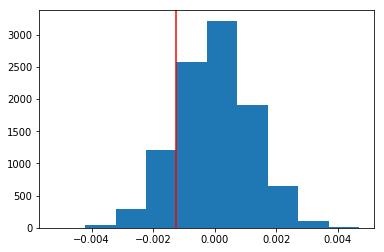

In [30]:
plt.hist(p_diffs)
plt.axvline(-0.00127,color='red')

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
actual_diff = treat-cont
pd_df = pd.DataFrame(p_diffs)
pd_df.columns = ['a']
len(pd_df.query('a > @actual_diff'))/len(pd_df)

0.8978

I calculated the critical value- the threshold for the practical significance in the differences between the new and old pages. Eighty-five percent of the differences were greater than the line.

In [32]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


Since the z-score of `-0.0247046451343` is less than the critical value of `1.959963984540054` and the p-value is so high at `0.51`, we can fail to reject the null hypotesis.

<a id='regression'></a>
### Part III - A regression approach

Logistic Regression

Logistic Regression

The goal is to use **statsmodels** to fit the regression model in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [35]:
df2['intercept']=1
df2[['ab_page','old_page']]= pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


In [36]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Mar 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:40:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with **ab_page** is 0.190. Because it is greater than 0.05 we fail to reject the null hypothesis, which in this case is that the new landing page is less effective or equal to the old one. <br><br>In Part II, the test identified whether the average conversion rates differ between page A and page B visitors in the population. A logistic regression estimates how the conversion rate varies by page visited. In other words, we're comparing the differences between two samples as opposed to the relationship between a dependent and independent variable. Moreover, the simulation and the z-test were one-sided tests, whereas the regression was not. <br><Br>

There are many factors that might influence whether or not someone converts besides which landing page they hit. For example, whether or not they are in the target market, which may be identified by age, gender, or other demographic information, might directly influence whether or not someone buys. Of course, when adding additional terms into the regressional model it's important to consider that they are not correlated; for exmaple, we wouldn't want to add both interest in softball and gender because those are correlated.

Does it appear that country had an impact on conversion? 

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [39]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('US', axis = 1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [40]:
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 16 Mar 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:40:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Country did not have significant effect on conversion rate.

But could page *and* country?

In [41]:
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK', 'ab_page']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Mar 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:40:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

All of the p-values related to country or page are wll past the .05 threshold, or even the .1 threshold if we were being generous. I would say none of these factors are particularly good predictors of conversion. 